<h2><center>Notebook Walk-through: </center>
    
<center>Fine-Tuning BERT - Optimizer Considerations and Layer Freezing
</center></h2>

In this notebook we discuss some aspects of BERT Fine-tuning for a specific task. We choose a text classification as an example. We will highlight various aspects you may encounter.

Specifically, we will:

* play with BERT (Hugging Face implementation): Tokenization, Layers and Output Dimensions  
* build a sentiment classifier with BERT from scratch and discuss a couple of options you may have
* train the network with various configurations and make observations that will hopefully be helpful

Note that a lot of the content will be delivered through live experimentation in the walkthrough session, and it will not be recorded in the notebook. Please watch the recording. 

Also, note that we are not attempting to reach state of the art by any means. The purpose of the notebook is to highlight some of the issues you may want to consider when fine-tuning BERT.

We start with a few common imports.


In [1]:
from google.colab import (drive, files)
import pandas as pd
import numpy as np
import sklearn
import os

import tensorflow as tf
import tensorflow_datasets as tfds

!pip install -q transformers

import transformers

from transformers import BertTokenizer, TFBertModel, BertConfig
from tensorflow.keras import backend as K


import logging
tf.get_logger().setLevel(logging.ERROR)

     |████████████████████████████████| 4.0 MB 15.0 MB/s 
     |████████████████████████████████| 6.5 MB 50.0 MB/s 
     |████████████████████████████████| 77 kB 6.6 MB/s 
     |████████████████████████████████| 596 kB 54.0 MB/s 
     |████████████████████████████████| 895 kB 57.1 MB/s 


In [2]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
import sklearn.model_selection
import sklearn.preprocessing as preproc
from sklearn.feature_extraction import text

import sklearn.metrics as metrics


Let's check for presence of a GPU. We'll need that (or better) if we use transformer models like BERT. 

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

Next, let's specify the versions that we are using:

In [4]:
tf.__version__

'2.8.0'

In [5]:
transformers.__version__

'4.18.0'

#### TODO
1) Import our data


In [6]:
drive.mount('/content/gdrive', force_remount=True)
path = "/content/gdrive"
os.chdir(path)

Mounted at /content/gdrive


In [7]:
## Get our cleaned data (from the DataCreation2.ipynb), which is stored in good_lyrics_data.csv
df = pd.read_csv('MyDrive/W266_Final_Project/good_lyrics_data.csv')
df

,Year,Yearly Rank,Title,Artist(s),Lyrics,Num Chars,Num Words,Decade
0,1960,2,"""Cathy's Clown""",The Everly Brothers,Cathy’s Clown Lyrics[Chorus] Don't want your l...,827,156,1960s
1,1960,8,"""Stuck on You""",Elvis Presley,Stuck on You Lyrics[Verse 1] You can shake an ...,1242,242,1960s
2,1960,9,"""The Twist""",Chubby Checker,The Twist Lyrics[Chorus:] Come on baby let's d...,754,147,1960s
3,1960,14,"""El Paso""",Marty Robbins,El Paso Lyrics[Verse 1] Out in the West Texas ...,2465,496,1960s
4,1960,15,"""Alley Oop""",The Hollywood Argyles,"Alley-Oop Lyrics[Intro] (Oop-oop, oop, oop-oop...",1859,299,1960s
...,...,...,...,...,...,...,...,...
3542,2021,94,"""Single Saturday Night""",Cole Swindell,Single Saturday Night Lyrics[Verse 1] I was ou...,2038,390,2020s
3543,2021,95,"""Things a Man Oughta Know""",Lainey Wilson,Things a Man Oughta Know Lyrics[Verse 1] I can...,1341,298,2020s
3544,2021,96,"""Throat Baby (Go Baby)""",BRS Kash,Throat Baby (Go Baby) Lyrics[Intro] (What's ha...,3042,615,2020s
3545,2021,97,"""Tombstone""",Rod Wave,"Tombstone Lyrics[Intro] Damn, this motherfucke...",2086,393,2020s


In [8]:
bert_df = df[["Lyrics", "Decade", "Year", "Title", "Artist(s)"]]
bert_df

,Lyrics,Decade,Year,Title,Artist(s)
0,Cathy’s Clown Lyrics[Chorus] Don't want your l...,1960s,1960,"""Cathy's Clown""",The Everly Brothers
1,Stuck on You Lyrics[Verse 1] You can shake an ...,1960s,1960,"""Stuck on You""",Elvis Presley
2,The Twist Lyrics[Chorus:] Come on baby let's d...,1960s,1960,"""The Twist""",Chubby Checker
3,El Paso Lyrics[Verse 1] Out in the West Texas ...,1960s,1960,"""El Paso""",Marty Robbins
4,"Alley-Oop Lyrics[Intro] (Oop-oop, oop, oop-oop...",1960s,1960,"""Alley Oop""",The Hollywood Argyles
...,...,...,...,...,...
3542,Single Saturday Night Lyrics[Verse 1] I was ou...,2020s,2021,"""Single Saturday Night""",Cole Swindell
3543,Things a Man Oughta Know Lyrics[Verse 1] I can...,2020s,2021,"""Things a Man Oughta Know""",Lainey Wilson
3544,Throat Baby (Go Baby) Lyrics[Intro] (What's ha...,2020s,2021,"""Throat Baby (Go Baby)""",BRS Kash
3545,"Tombstone Lyrics[Intro] Damn, this motherfucke...",2020s,2021,"""Tombstone""",Rod Wave


In [9]:
## Create Train/Val/Test Split (in 2 steps)
train, rem = sklearn.model_selection.train_test_split(bert_df, train_size = 0.7, random_state=42)
val, test = sklearn.model_selection.train_test_split(rem, train_size = 0.5, random_state = 43)

print("Train Shape: ", train.shape)
print("Val Shape:   ", val.shape)
print("Test Shape:  ", test.shape)
train.head(3)

Train Shape:  (2482, 5)
Val Shape:    (532, 5)
Test Shape:   (533, 5)


,Lyrics,Decade,Year,Title,Artist(s)
944,Off the Wall Lyrics[Verse 1] When the world is...,1980s,1980,"""Off the Wall""",Michael Jackson
199,"Bus Stop LyricsBus stop, wet day She's there, ...",1960s,1966,"""Bus Stop""",The Hollies
3351,Lucid Dreams Lyrics[Intro] Enviyon on the mix ...,2010s,2018,"""Lucid Dreams""",Juice Wrld


### 2. Preparing the model input with the BERT Tokenizer

We use the 'bert-base-cased' from Huggingface as the underlying BERT model.

In [10]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
config = BertConfig(hidden_dropout_prob = 0.25)
bert_model = TFBertModel.from_pretrained('bert-base-cased', config)

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/502M [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [11]:
train["Lyrics"]

944     Off the Wall Lyrics[Verse 1] When the world is...
199     Bus Stop LyricsBus stop, wet day She's there, ...
3351    Lucid Dreams Lyrics[Intro] Enviyon on the mix ...
2276    He Can’t Love U Lyrics[Intro: Brandon] I ain't...
801     With a Little Luck Lyrics[Verse 1] With a litt...
                              ...                        
1130    You Got Lucky Lyrics[Intro] One, two  [Verse 1...
1294    Kiss Lyrics[Verse 1] You don't have to be beau...
860     What a Fool Believes Lyrics[Verse 1] He came f...
3507    Heat Waves Lyrics[Intro] (Last night, all I th...
3174    Partition Lyrics[Part 1: "Yoncé"]  [Intro] Let...
Name: Lyrics, Length: 2482, dtype: object

In [12]:
## check: do we get the ouput we want? YES!
# tokenizer([x for x in train["Lyrics"]], 
#               max_length=max_length,
#               truncation=True,
#               padding='max_length', 
#               return_tensors='tf')

In [13]:
pd.get_dummies(train["Decade"]) # to one-hot

,1960s,1970s,1980s,1990s,2000s,2010s,2020s
944,0,0,1,0,0,0,0
199,1,0,0,0,0,0,0
3351,0,0,0,0,0,1,0
2276,0,0,0,0,1,0,0
801,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...
1130,0,0,1,0,0,0,0
1294,0,0,1,0,0,0,0
860,0,1,0,0,0,0,0
3507,0,0,0,0,0,0,1


In [34]:
max_length = 512

x_train = tokenizer([x for x in train["Lyrics"]], 
              max_length=max_length,
              truncation=True,
              padding='max_length', 
              return_tensors='tf')
y_train = pd.get_dummies(train["Decade"])
meta_train = train[["Decade", "Year", "Title", "Artist(s)"]]

x_val = tokenizer([x for x in val["Lyrics"]], 
              max_length=max_length,
              truncation=True,
              padding='max_length', 
              return_tensors='tf')
y_val = pd.get_dummies(val["Decade"])
meta_val = val[["Decade", "Year", "Title", "Artist(s)"]]


x_test = tokenizer([x for x in test["Lyrics"]], 
              max_length=max_length,
              truncation=True,
              padding='max_length', 
              return_tensors='tf')
y_test = pd.get_dummies(test["Decade"])
meta_test = test[["Decade", "Year", "Title", "Artist(s)"]]




In [15]:
meta_train.head(3)

,Year,Title,Artist(s)
944,1980,"""Off the Wall""",Michael Jackson
199,1966,"""Bus Stop""",The Hollies
3351,2018,"""Lucid Dreams""",Juice Wrld


In [16]:

y_train.shape

(2482, 7)

In [17]:
x_train

{'input_ids': <tf.Tensor: shape=(2482, 512), dtype=int32, numpy=
array([[  101,  8060,  1103, ...,  2551,  1106,   102],
       [  101,  8947,  6682, ...,     0,     0,     0],
       [  101, 13174,  2386, ...,  1267,  1240,   102],
       ...,
       [  101,  1327,   170, ...,     0,     0,     0],
       [  101,  9653, 13531, ...,  8552,  1179,   102],
       [  101,  4539,  8934, ...,  9562,   112,   102]], dtype=int32)>, 'token_type_ids': <tf.Tensor: shape=(2482, 512), dtype=int32, numpy=
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(2482, 512), dtype=int32, numpy=
array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]], dtype=in

In [18]:
x_train.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

input_ids are the ones we really care about

### 3. BERT



**Questions:**
* What are the interpretations of the 3 outputs?
* Are the respective dimensions as expected?

### 4. Building our Classification Model (from scratch)

Let's build our classification model from scratch and run a few configurations.

In particular, we will consider:

* Optimizer choices
* number of bert layers to be re-trained
* effects of freezing and unfreezing


### 5. Build Classification Model (for real)

In [19]:
def create_classification_model(hidden_size = 200, 
                                train_layers = -1, 
                                optimizer=tf.keras.optimizers.Adam()):
    """
    Build a simple classification model with BERT. Let's keep it simple and don't add dropout, layer norms, etc.
    """

    input_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32, name='input_ids_layer')
    token_type_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32, name='token_type_ids_layer')
    attention_mask = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32, name='attention_mask_layer')

    bert_inputs = {'input_ids': input_ids,
                  'token_type_ids': token_type_ids,
                  'attention_mask': attention_mask}


    #restrict training to the train_layers outer transformer layers
    if not train_layers == -1:

            retrain_layers = []

            for retrain_layer_number in range(train_layers):

                layer_code = '_' + str(11 - retrain_layer_number)
                retrain_layers.append(layer_code)

            for w in bert_model.weights:
                if not any([x in w.name for x in retrain_layers]):
                    w._trainable = False


    bert_out = bert_model(bert_inputs)


    classification_token = tf.keras.layers.Lambda(lambda x: x[:,0,:], name='get_first_vector')(bert_out[0])


    #hidden = tf.keras.layers.Dense(hidden_size, name='hidden_layer')(classification_token)

    classification = tf.keras.layers.Dense(7, activation='softmax',name='classification_layer')(classification_token)

    classification_model = tf.keras.Model(inputs=[input_ids, token_type_ids, attention_mask], 
                                          outputs=[classification])
    
    classification_model.compile(optimizer=optimizer,
                            loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False), #catgorical cross entropy for multi class classifcation
                            metrics='accuracy')


    return classification_model

### 5. Experimentation

Let us compare a few configurations:

* 'default': Adam Optimizer with default parameters (lr=0.001), all BERT layers fine-tuned 
* 'smaller learning rate': Adam Optimizer with lr=0.00005 parameters, all BERT layers fine-tuned 
* 'frozen': Adam Optimizer with default parameters, all BERT layers frozen

#### 5.1 Default -- doesn't learn


In [20]:
#classification_model = create_classification_model()     

In [21]:
# classification_model.fit([x_train.input_ids, x_train.token_type_ids, x_train.attention_mask],
#                          y_train,
#                          validation_data=([x_val.input_ids, x_val.token_type_ids, x_val.attention_mask],
#                          y_val),
#                         epochs=3,
#                         batch_size=8)

#classification_model([x.input_ids, x.token_type_ids, x.attention_mask])

In [22]:
# classification_model.predict([x_train.input_ids, x_train.token_type_ids, x_train.attention_mask], 
#                              batch_size=8, 
#                              steps=2)

What is this? All essentially the same prediction? And basically not better than always predicting the majority class for each example? It may seem like "BERT is no good for this task"?!

Careful, not so! There are a number of changes one can consider:

* Change the optimizer configuration
* Freeze some BERT layers - maybe for the entire training cycle or for thye first few epochs. 
* Add more data


#### 5.2 Lower Learning Rate


In [24]:
try:
    del classification_model
except:
    pass

try:
    del bert_model
except:
    pass

tf.keras.backend.clear_session()
bert_model = TFBertModel.from_pretrained('bert-base-cased', config)

classification_model = create_classification_model(optimizer=tf.keras.optimizers.Adam(0.00005))

classification_model.fit([x_train.input_ids, x_train.token_type_ids, x_train.attention_mask],
                         y_train,
                         validation_data=([x_val.input_ids, x_val.token_type_ids, x_val.attention_mask],
                         y_val),
                        epochs=5,
                        batch_size=8)

## Commented out to run below after i interupt this training
# classification_model.predict([x_train.input_ids, x_train.token_type_ids, x_train.attention_mask], 
#                              batch_size=8, 
#                              steps=2)

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/5
311/311 [==============================] - 214s 641ms/step - loss: 1.7552 - accuracy: 0.2728 - val_loss: 1.5191 - val_accuracy: 0.3195
Epoch 2/5
311/311 [==============================] - 197s 632ms/step - loss: 1.4145 - accuracy: 0.4138 - val_loss: 1.4696 - val_accuracy: 0.4004
Epoch 3/5
311/311 [==============================] - 196s 632ms/step - loss: 0.9710 - accuracy: 0.6060 - val_loss: 1.6166 - val_accuracy: 0.4023
Epoch 4/5
311/311 [==============================] - 197s 632ms/step - loss: 0.5658 - accuracy: 0.7853 - val_loss: 2.0724 - val_accuracy: 0.4361
Epoch 5/5
311/311 [==============================] - 196s 632ms/step - loss: 0.3084 - accuracy: 0.8973 - val_loss: 2.3293 - val_accuracy: 0.4398


### Results

[see this google sheet](https://docs.google.com/spreadsheets/d/1DFTXUfE2SE4XCt-m4__YyI2BEb5miCl5WsLaXUOVExQ/edit?usp=sharing)

In [25]:
meta_train[:16]

,Year,Title,Artist(s)
944,1980,"""Off the Wall""",Michael Jackson
199,1966,"""Bus Stop""",The Hollies
3351,2018,"""Lucid Dreams""",Juice Wrld
2276,2000,"""He Can't Love U""",Jagged Edge
801,1978,"""With a Little Luck""",Wings
2319,2001,"""Love Don't Cost a Thing""",Jennifer Lopez
1403,1987,"""Diamonds""",Herb Alpert
3336,2017,"""Too Good at Goodbyes""",Sam Smith
231,1966,"""Along Comes Mary""",The Association
1108,1983,"""Overkill""",Men at Work


In [26]:
classification_model.predict([x_train.input_ids, x_train.token_type_ids, x_train.attention_mask], 
                             batch_size=8, 
                             steps=2)

array([[1.2751335e-06, 3.0400010e-04, 9.9962962e-01, 6.0167080e-05,
        1.7243163e-06, 2.4773317e-06, 7.4314636e-07],
       [9.9955076e-01, 4.0116545e-04, 2.1775957e-05, 2.0425758e-05,
        1.3585295e-06, 1.2749016e-06, 3.2305670e-06],
       [3.6182198e-07, 6.8562454e-06, 1.6801527e-05, 3.2817974e-04,
        2.9420254e-03, 9.8411131e-01, 1.2594480e-02],
       [9.0393323e-06, 2.4530947e-05, 8.7182598e-05, 1.2763549e-03,
        8.7579274e-01, 1.2237363e-01, 4.3654267e-04],
       [3.4939277e-04, 9.9928743e-01, 3.5356928e-04, 6.8326403e-06,
        6.1562190e-07, 2.0973881e-07, 2.0405607e-06],
       [1.7406876e-06, 3.6181402e-06, 1.3402762e-05, 4.4255662e-03,
        9.8234326e-01, 1.2492244e-02, 7.2020327e-04],
       [2.8092822e-05, 1.1328346e-05, 9.9968934e-01, 2.6481261e-04,
        5.3627541e-06, 9.7434895e-07, 1.3663198e-07],
       [1.6360362e-05, 6.0541341e-05, 4.0176811e-04, 1.8160160e-04,
        2.8734345e-03, 9.5799792e-01, 3.8468290e-02],
       [9.9261510e-01, 7

Try get Test Results

In [27]:
classification_model.evaluate([x_test.input_ids, x_test.token_type_ids, x_test.attention_mask], y_test, batch_size = 8)

67/67 [==============================] - 14s 209ms/step - loss: 2.2802 - accuracy: 0.4371


[2.2801918983459473, 0.43714821338653564]

In [29]:
output = classification_model.predict([x_test.input_ids, x_test.token_type_ids, x_test.attention_mask],
                             batch_size=8)
output

array([[4.70609628e-02, 4.94036358e-03, 7.94903219e-01, ...,
        2.82611181e-05, 9.76729370e-06, 6.04252727e-06],
       [3.60173784e-04, 9.80118513e-01, 1.36498660e-02, ...,
        5.86280512e-05, 1.32869709e-05, 3.34419092e-05],
       [2.00388692e-02, 9.74613070e-01, 3.83882131e-03, ...,
        1.76184142e-06, 1.17329924e-04, 2.90299213e-05],
       ...,
       [2.91052944e-04, 9.66109931e-01, 4.20782110e-03, ...,
        6.65811414e-04, 9.11299139e-04, 7.23455087e-05],
       [6.59334779e-01, 3.13554019e-01, 1.71083584e-03, ...,
        2.05919915e-03, 2.15943335e-04, 4.75777924e-04],
       [2.58210912e-06, 4.23121674e-06, 3.33263756e-06, ...,
        8.88172630e-03, 4.27087277e-01, 5.63931048e-01]], dtype=float32)

In [35]:
len(output)

533

In [40]:
np.argmax(output[0])
output[0][1]

decade_dict = {0: "1960s", 1: "1970s", 2: "1980s", 3: "1990s", 4: '2000s', 5: "2010s", 6: "2020s"}

y_pred_test = []

for scores in output:
  place = np.argmax(scores)
  dec = decade_dict.get(place)
  y_pred_test.append(dec)
  #print(b)
  print(dec, scores[place])
  #print(scores[place])

1980s 0.7949032
1970s 0.9801185
1970s 0.9746131
1960s 0.6341702
1970s 0.98397094
1980s 0.3857638
2000s 0.57993203
1980s 0.9953387
1980s 0.8037137
1990s 0.41512877
1960s 0.62751514
1990s 0.9187737
2000s 0.6619047
2010s 0.96120256
1970s 0.4052189
1970s 0.97090137
2000s 0.86185217
1970s 0.9700837
1970s 0.9961041
1970s 0.90904754
1960s 0.96368754
1970s 0.8456922
1990s 0.8612364
2010s 0.5314307
1980s 0.9525064
1990s 0.5686734
1970s 0.8556325
1970s 0.7640822
1970s 0.8372921
1970s 0.9634904
2010s 0.99540293
2010s 0.8697721
2000s 0.5120611
1990s 0.89010674
1980s 0.99675673
1980s 0.40733418
1990s 0.9405296
1980s 0.9565929
1980s 0.85097796
1960s 0.9988224
1990s 0.72645414
2010s 0.9625786
1960s 0.6938185
2010s 0.9858969
1980s 0.74798864
1990s 0.7411161
1970s 0.9732729
1960s 0.9975236
2010s 0.8885231
2010s 0.3331468
1990s 0.94317955
1970s 0.99037254
1960s 0.52871615
1980s 0.72406745
1990s 0.5948879
1980s 0.7394759
2010s 0.90838957
1970s 0.7960407
1990s 0.86554325
1960s 0.7549034
2000s 0.5669373
19

In [42]:
y_pred_test[:5]

['1980s', '1970s', '1970s', '1960s', '1970s']

[Text(0.5, 0, '1960s'),
 Text(1.5, 0, '1970s'),
 Text(2.5, 0, '1980s'),
 Text(3.5, 0, '1990s'),
 Text(4.5, 0, '2000s'),
 Text(5.5, 0, '2010s'),
 Text(6.5, 0, '2020s')]

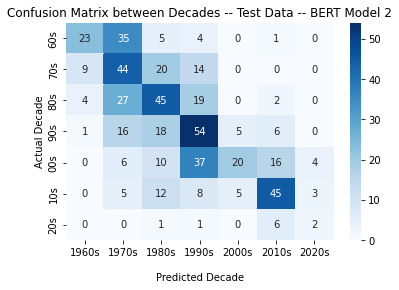

In [51]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cfn_matrix = confusion_matrix(meta_test["Decade"], y_pred_test)
ax = sns.heatmap(cfn_matrix, annot=True, cmap = 'Blues')

ax.set_title('Confusion Matrix between Decades -- Test Data -- BERT Model 2');
ax.set_xlabel('\nPredicted Decade')
ax.set_ylabel('Actual Decade');

## Ticket labels - List must be in alphabetical order
ax.yaxis.set_ticklabels(['60s','70s', '80s', '90s', '00s', '10s', '20s'])
ax.xaxis.set_ticklabels(['1960s','1970s', '1980s', '1990s', '2000s', '2010s', '2020s'])

In [37]:
meta_test[:16]

,Decade,Year,Title,Artist(s)
1580,1990s,1990,"""I Don't Have the Heart""",James Ingram
756,1970s,1977,"""Lucille""",Kenny Rogers
3436,2010s,2019,"""Baby Shark""",Pinkfong
70,1960s,1962,"""Town Without Pity""",Gene Pitney
2626,2000s,2006,"""Bad Day""",Daniel Powter
2313,2000s,2001,"""Follow Me""",Uncle Kracker
2366,2000s,2001,"""You Shouldn't Kiss Me Like This""",Toby Keith
1360,1980s,1987,"""Head to Toe""",Lisa Lisa and Cult Jam
1977,1990s,1996,"""Insensitive""",Jann Arden
2831,2000s,2009,"""Hotel Room Service""",Pitbull


In [151]:

[print(a) for a in output[5]]

8.778018e-05
0.0008411229
0.006952244
0.179679
0.80254126
0.008470657
0.0014279548


[None, None, None, None, None, None, None]

That seemed to work! Looks like the learning rate really mattered! (Of course, we have not focused here on finding the model for the test accuracy. We simply wanted to 'get it to work').

#### 5.3 Layer Freezing

In [ ]:
try:
    del classification_model
except:
    pass

try:
    del bert_model
except:
    pass

tf.keras.backend.clear_session()
bert_model = TFBertModel.from_pretrained('bert-base-cased')

classification_model = create_classification_model(train_layers=0, optimizer=tf.keras.optimizers.Adam(0.00005))

classification_model.fit([x_train.input_ids, x_train.token_type_ids, x_train.attention_mask],
                         y_train,
                         validation_data=([x_val.input_ids, x_val.token_type_ids, x_val.attention_mask],
                         y_val),
                        epochs=5,
                        batch_size=8)

## Commented out to run below after i interupt this training
# classification_model.predict([x_train.input_ids, x_train.token_type_ids, x_train.attention_mask], 
#                              batch_size=8, 
#                              steps=2)

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/5
311/311 [==============================] - 147s 455ms/step - loss: 1.8666 - accuracy: 0.2143 - val_loss: 1.7656 - val_accuracy: 0.2425
Epoch 2/5
311/311 [==============================] - 139s 446ms/step - loss: 1.7815 - accuracy: 0.2413 - val_loss: 1.7225 - val_accuracy: 0.2914
Epoch 3/5
311/311 [==============================] - 139s 446ms/step - loss: 1.7452 - accuracy: 0.2591 - val_loss: 1.7116 - val_accuracy: 0.3083
Epoch 4/5
311/311 [==============================] - 138s 446ms/step - loss: 1.7346 - accuracy: 0.2760 - val_loss: 1.6789 - val_accuracy: 0.2970
Epoch 5/5
311/311 [==============================] - 138s 445ms/step - loss: 1.7059 - accuracy: 0.2869 - val_loss: 1.6942 - val_accuracy: 0.2726


In [ ]:
classification_model.predict([x_train.input_ids, x_train.token_type_ids, x_train.attention_mask], 
                             batch_size=8, 
                             steps=2)

array([[0.10838161, 0.12395237, 0.11297233, 0.2545635 , 0.20368686,
        0.17494014, 0.02150316],
       [0.33020565, 0.1948801 , 0.14751196, 0.1926287 , 0.08554932,
        0.04023276, 0.00899153],
       [0.05219409, 0.03676203, 0.05673169, 0.35943377, 0.32667145,
        0.15617442, 0.01203257],
       [0.04303299, 0.03225997, 0.0410823 , 0.3011085 , 0.44117025,
        0.12901987, 0.01232615],
       [0.11723087, 0.12768649, 0.1269095 , 0.3073693 , 0.18083014,
        0.12007658, 0.01989715],
       [0.06708151, 0.05153055, 0.07156489, 0.3884395 , 0.3004704 ,
        0.10505016, 0.01586301],
       [0.11188804, 0.11146164, 0.16245691, 0.4072772 , 0.13227688,
        0.06358927, 0.01105001],
       [0.08536007, 0.08014455, 0.10582654, 0.27618316, 0.22742192,
        0.1999968 , 0.02506698],
       [0.14888608, 0.2028337 , 0.15904713, 0.24803303, 0.15255906,
        0.07070753, 0.01793355],
       [0.4084347 , 0.217292  , 0.18999252, 0.11151483, 0.05053005,
        0.01715338, 0.0

That 'worked' too! As expected, the final validation loss is larger and the validation accuracy is smaller though.

**Questions:**
* is that expected? 
* What else is different?

But either way, all of these parameters seem to be interrelated. Experiment!

---

#### Idea for Viz of output

Similarity matrix for 10 "well-known" songs

Y = True Decade,
X = Pred Decade

further apart = redder. exactly on = green

---

### 6. Conclusions 

While one has to be careful to generalize from one (truncated) dataset, the pattern is pretty clear: it is not enough to simply define the model and see what you get. Some investigation needs to be devoted to making sure that the combination of model details, optimizer configurations, and data work.

One big tell is if a BERT model is not better than ~'pick the majority class' or close to it, while other models perform better. 

One should also say that there are other things to try in the learning phase, but the point of this notebook was to point out a few obvious issues. Previous students ran into precisely these issues!